In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


## 11110COM 526000 Deep Learning HW2:Variational Autoencoder

## Don't change the below two functions (compute_PSNR, compute_SSIM)!!
def compute_PSNR(img1, img2): ## 請輸入範圍在0~1的圖片!!!
    # Compute Peak Signal to Noise Ratio (PSNR) function
    # img1 and img2 > [0, 1] 
    
    img1 = torch.as_tensor(img1, dtype=torch.float32)# In tensor format!!
    img2 = torch.as_tensor(img2, dtype=torch.float32)
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(1 / torch.sqrt(mse))

def compute_SSIM(img1, img2): ## 請輸入範圍在0~1的圖片!!!
    # Compute Structure Similarity (SSIM) function
    # img1 and img2 > [0, 1]
    C1 = (0.01 * 1) ** 2
    C2 = (0.03 * 1) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()



In [2]:
lr = 0.001
epoch = 100
batch = 20

In [3]:

## Feel free to adjust the codes in the hw2_template.py !!!

## Read the data
x = torch.tensor(np.load('eye/data.npy').astype(np.float32))
y = torch.tensor(np.load('eye/label.npy').astype(np.float32))
dataset = TensorDataset(x, y)
loader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch)
total_loader = DataLoader(dataset=dataset, shuffle=True)


In [4]:
# print(np.load('eye/data.npy').astype(np.float32).shape)
# plt.imshow(np.load('eye/data.npy').astype(np.float32)[0])

In [5]:
torch.cuda.set_device(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class ae(nn.Module):
    def __init__(self):
        super(ae, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*50*50, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 3*50*50),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ae().to(device)
print(model)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_his = []

# train
for e in range(epoch):
    train_loss = 0.0
    for d in loader:
        img, _ = d
        input_img = img.view(-1, 50*50*3).to(device)
        output = model(input_img).view(-1, 50, 50, 3)
        loss = loss_func(output, input_img.view(-1, 50, 50, 3))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss
  # print avg training statistics 
    train_loss = train_loss/len(loader)
    loss_his.append(train_loss.detach().cpu().item())
    if e%10 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          e, 
          train_loss
          ))

# evaluate
total_PSNR = 0
total_SSIM = 0
for d in total_loader:
    img, _ = d
    input_img = img.view(-1, 50*50*3).to(device)
    output = model(input_img).view(-1, 50, 50, 3).detach().cpu()
    total_PSNR += compute_PSNR(img.numpy().reshape(50,50,3), output.numpy().reshape(50,50,3))
    total_SSIM += compute_SSIM(img.numpy().reshape(50,50,3), output.numpy().reshape(50,50,3))
print('average PSNR={}, SSIM={}'.format(total_PSNR/len(total_loader), total_SSIM/len(total_loader)))

  

ae(
  (encoder): Sequential(
    (0): Linear(in_features=7500, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=7500, bias=True)
    (3): Sigmoid()
  )
)
Epoch: 0 	Training Loss: 0.035045
Epoch: 10 	Training Loss: 0.009434
Epoch: 20 	Training Loss: 0.007379
Epoch: 30 	Training Loss: 0.006461
Epoch: 40 	Training Loss: 0.005921
Epoch: 50 	Training Loss: 0.005546
Epoch: 60 	Training Loss: 0.005226
Epoch: 70 	Training Loss: 0.004921
Epoch: 80 	Training Loss: 0.004731
Epoch: 90 	Training Loss: 0.004522
average PSNR=24.04361915588379, SSIM=0.6841096557718379


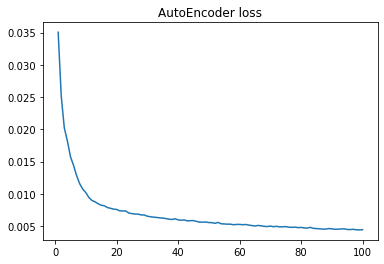

In [13]:
y_ = loss_his
x_ = np.array([i for i in range(1,101)])
plt.title('AutoEncoder loss')
plt.plot(x_, y_)

In [14]:
# save model
torch.save(model.state_dict(), 'AE.pth')

In [ ]:
# load model
# m = ae().to(device)
# m.load_state_dict(torch.load('AE.pth'))
# m.eval()

In [ ]:
# total_PSNR = 0
# total_SSIM = 0
# for d in total_loader:
#     img, _ = d
#     input_img = img.view(-1, 50*50*3).to(device)
#     output = m(input_img).view(-1, 50, 50, 3).detach().cpu()
#     total_PSNR += compute_PSNR(img.numpy().reshape(50,50,3), output.numpy().reshape(50,50,3))
#     total_SSIM += compute_SSIM(img.numpy().reshape(50,50,3), output.numpy().reshape(50,50,3))
# print('average PSNR={}, SSIM={}'.format(total_PSNR/len(total_loader), total_SSIM/len(total_loader)))

  
  